In [1]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
import seaborn as sns
from scipy import stats
sc.set_figure_params(dpi_save=300)

/Users/Future/Library/Python/3.6/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_to_save = "../results/Figures/Supplemental Figure 7/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

In [3]:
def umap_visualize(adata, n_out, figure, palette):
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=["heldout"],
               legend_fontsize=20,
               palette=palette,
               frameon=False,
               title="",
               save=f"_heldout_{n_out}.png",
               show=True)
    os.rename(src=os.path.join(path_to_save, f"umap_heldout_{n_out}.png"), 
              dst=os.path.join(path_to_save, f"SupplFig6{figure}_heldout_{n_out}.png"))

In [11]:
def umap_heldout(adata, c_in, c_out, figure):
    adata.obs["heldout"] = "train/validation"
    adata.obs.loc[(adata.obs["cell_type"].isin(c_out)) & (adata.obs["condition"] == "stimulated"), "heldout"] = "holdout"
    print(adata.obs.groupby(['heldout']).size())
    print(adata.obs.groupby(['cell_type', 'heldout']).size())
    umap_visualize(adata, len(c_out), figure, palette=["#22c2e5", "#ffd600"])

In [5]:
def replace_conditions(adata):
    adata.obs["condition"].replace("CD4T_ctrl", "CD4-T_ctrl", inplace=True)
    adata.obs["condition"].replace("CD4T_real_stim", "CD4-T_real_stim", inplace=True)
    adata.obs["condition"].replace("CD4T_pred_stim", "CD4-T_pred_stim", inplace=True)

    adata.obs["condition"].replace("CD8T_ctrl", "CD8-T_ctrl", inplace=True)
    adata.obs["condition"].replace("CD8T_real_stim", "CD8-T_real_stim", inplace=True)
    adata.obs["condition"].replace("CD8T_pred_stim", "CD8-T_pred_stim", inplace=True)

    adata.obs["condition"].replace("Dendritic_ctrl", "DC_ctrl", inplace=True)
    adata.obs["condition"].replace("Dendritic_real_stim", "DC_real_stim", inplace=True)
    adata.obs["condition"].replace("Dendritic_pred_stim", "DC_pred_stim", inplace=True)

    adata.obs["condition"].replace("FCGR3A+Mono_ctrl", "F-Mono_ctrl", inplace=True)
    adata.obs["condition"].replace("FCGR3A+Mono_real_stim", "F-Mono_real_stim", inplace=True)
    adata.obs["condition"].replace("FCGR3A+Mono_pred_stim", "F-Mono_pred_stim", inplace=True)

    adata.obs["condition"].replace("CD14+Mono_ctrl", "CD14-Mono_ctrl", inplace=True)
    adata.obs["condition"].replace("CD14+Mono_real_stim", "CD14-Mono_real_stim", inplace=True)
    adata.obs["condition"].replace("CD14+Mono_pred_stim", "CD14-Mono_pred_stim", inplace=True)
def replace_cell_types(adata):
    adata.obs["cell_type"].replace("CD4T", "CD4-T", inplace=True)
    adata.obs["cell_type"].replace("CD8T", "CD8-T", inplace=True)
    adata.obs["cell_type"].replace("Dendritic", "DC", inplace=True)
    adata.obs["cell_type"].replace("FCGR3A+Mono", "F-Mono", inplace=True)
    adata.obs["cell_type"].replace("CD14+Mono", "CD14-Mono", inplace=True)

In [6]:
pbmc = sc.read("../data/train_pbmc.h5ad")
replace_cell_types(pbmc)
pbmc

AnnData object with n_obs × n_vars = 16893 × 6998 
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [7]:
pbmc.obs.groupby(['cell_type', 'condition']).size()

cell_type  condition 
B          control        818
           stimulated     993
CD14-Mono  control       1946
           stimulated     615
CD4-T      control       2437
           stimulated    3127
CD8-T      control        574
           stimulated     541
DC         control        615
           stimulated     463
F-Mono     control       1100
           stimulated    2501
NK         control        517
           stimulated     646
dtype: int64

In [9]:
def cell_type_analysis(adata, cell_type, n_out, figure, c_in, c_out):
    import scipy.sparse as sparse
    if sparse.issparse(adata.X):
        adata.X = adata.X.A
    network = scgen.VAEArith(x_dimension=adata.shape[1], z_dimension=100, model_path=f"../models/scGen/pbmc/heldout/{n_out}/models/scgen")
    network.restore_model()
    net_train_data = scgen.data_remover(adata, remain_list=c_in, remove_list=c_out,
                                        cell_type_key="cell_type", condition_key="condition")
    print(net_train_data.obs.groupby(['cell_type', 'condition']).size())
    conditions = {"stim": "stimulated", "ctrl": "control"}
    pred_stim, delta = network.predict(adata=net_train_data,
                                       conditions=conditions,
                                       cell_type_key="cell_type",
                                       condition_key="condition",
                                       celltype_to_predict=cell_type)
    cell_type_data = adata[adata.obs["cell_type"] == cell_type]
    pred_adata = anndata.AnnData(pred_stim, obs={"condition": ["pred"] * len(pred_stim)},
                                 var={"var_names": cell_type_data.var_names})
    
    all_adata = cell_type_data.concatenate(pred_adata)
    print(all_adata.obs.groupby(['condition']).size())
    sc.tl.rank_genes_groups(cell_type_data, groupby="condition", n_genes=100, method="wilcoxon")
    diff_genes = cell_type_data.uns["rank_genes_groups"]["names"]["stimulated"]
    scgen.plotting.reg_mean_plot(all_adata, 
                                 labels={"x": "pred", "y":"stim"},
                                 condition_key="condition",
                                 axis_keys={"x": "pred", "y": conditions["stim"]},
                                 gene_list=diff_genes[:5],
                                 top_100_genes=diff_genes,
                                 legend=False,
                                 fontsize=20,
                                 textsize=14, 
                                 range=[0, 6, 1],
                                 x_coeff=0.35,
                                 show=True,
                                 path_to_save=os.path.join(path_to_save, f"SupplFig7{figure}_{cell_type}_reg_mean.pdf"))
    import matplotlib
    matplotlib.rc('ytick', labelsize=18)
    matplotlib.rc('xtick', labelsize=18)
    sc.pl.violin(all_adata, keys="ISG15", groupby="condition",
                 save=f"_ISG15.pdf",
                 color = "#ee0ef0",
                 show=True)
    ctrl = cell_type_data[cell_type_data.obs['condition'] == 'control']
    stim = cell_type_data[cell_type_data.obs['condition'] == 'stimulated']
    print(f"Control: {ctrl.shape[0]}")
    print(f"Prediction: {pred_adata.shape[0]}")
    print(f"Stimulated: {stim.shape[0]}")
    os.rename(src=os.path.join(path_to_save, f"violin_ISG15.pdf"), 
              dst=os.path.join(path_to_save, f"SupplFig7{figure}_violin_ISG15_{cell_type}_{n_out}.pdf"))

heldout
holdout              5628
train/validation    11265
dtype: int64
cell_type  heldout         
B          train/validation    1811
CD4-T      holdout             3127
           train/validation    2437
CD8-T      train/validation    1115
CD14-Mono  train/validation    2561
DC         train/validation    1078
F-Mono     holdout             2501
           train/validation    1100
NK         train/validation    1163
dtype: int64


... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/umap_heldout_2.png


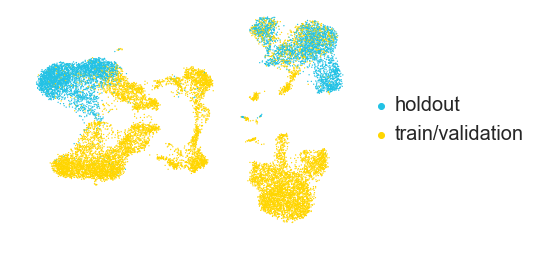

INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/heldout/2/models/scgen
cell_type  condition 
B          control        818
           stimulated     993
CD14-Mono  control       1946
           stimulated     615
CD4-T      control       2437
CD8-T      control        574
           stimulated     541
DC         control        615
           stimulated     463
F-Mono     control       1100
NK         control        517
           stimulated     646
dtype: int64
condition
control       2437
pred          2437
stimulated    3127
dtype: int64
0.9760360881287631
0.9752391599787549


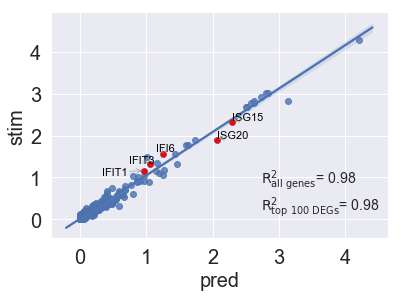

... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/violin_ISG15.pdf


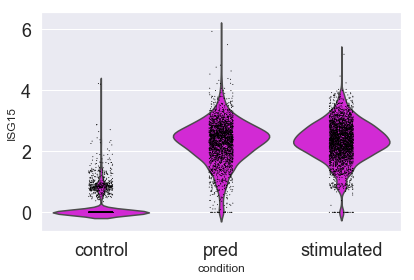

Control: 2437
Prediction: 2437
Stimulated: 3127
INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/heldout/2/models/scgen
cell_type  condition 
B          control        818
           stimulated     993
CD14-Mono  control       1946
           stimulated     615
CD4-T      control       2437
CD8-T      control        574
           stimulated     541
DC         control        615
           stimulated     463
F-Mono     control       1100
NK         control        517
           stimulated     646
dtype: int64
condition
control       1100
pred          1100
stimulated    2501
dtype: int64
0.8792809869064608
0.9356672765630973


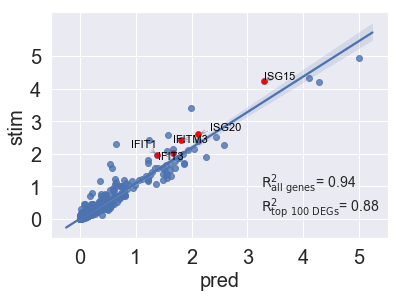

... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/violin_ISG15.pdf


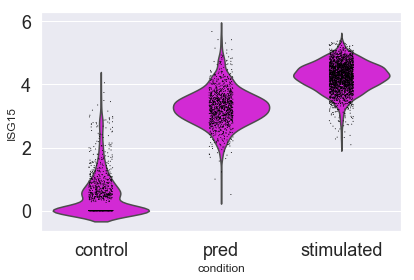

Control: 1100
Prediction: 1100
Stimulated: 2501


In [12]:
c_in = ['CD8-T', 'NK', 'B', 'DC', 'CD14-Mono']
c_out = ['CD4-T', 'F-Mono']
umap_heldout(pbmc, c_in, c_out, "a")
cell_type_analysis(pbmc, "CD4-T", 2, "a", c_in, c_out)
cell_type_analysis(pbmc, "F-Mono", 2, "a", c_in, c_out)

heldout
holdout              6632
train/validation    10261
dtype: int64
cell_type  heldout         
B          train/validation    1811
CD4-T      holdout             3127
           train/validation    2437
CD8-T      holdout              541
           train/validation     574
CD14-Mono  train/validation    2561
DC         holdout              463
           train/validation     615
F-Mono     holdout             2501
           train/validation    1100
NK         train/validation    1163
dtype: int64


... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/umap_heldout_4.png


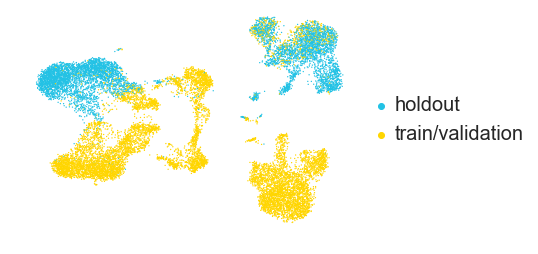

INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/heldout/4/models/scgen
cell_type  condition 
B          control        818
           stimulated     993
CD14-Mono  control       1946
           stimulated     615
CD4-T      control       2437
CD8-T      control        574
DC         control        615
F-Mono     control       1100
NK         control        517
           stimulated     646
dtype: int64
condition
control       2437
pred          2437
stimulated    3127
dtype: int64
0.9690310177931682
0.967485435982746


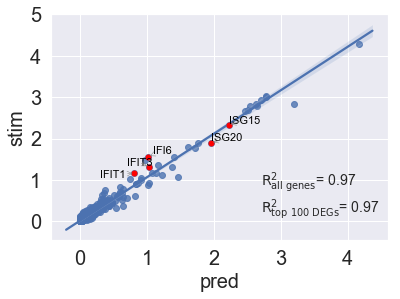

... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/violin_ISG15.pdf


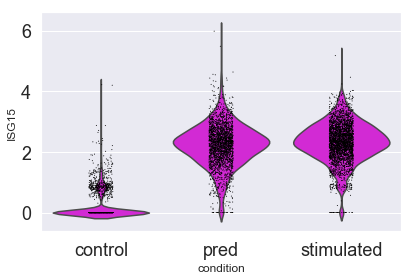

Control: 2437
Prediction: 2437
Stimulated: 3127
INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/heldout/4/models/scgen
cell_type  condition 
B          control        818
           stimulated     993
CD14-Mono  control       1946
           stimulated     615
CD4-T      control       2437
CD8-T      control        574
DC         control        615
F-Mono     control       1100
NK         control        517
           stimulated     646
dtype: int64
condition
control       1100
pred          1100
stimulated    2501
dtype: int64
0.8903661993636607
0.9347546660634535


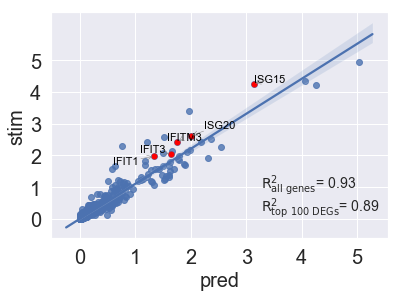

... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/violin_ISG15.pdf


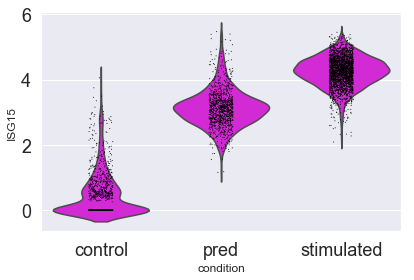

Control: 1100
Prediction: 1100
Stimulated: 2501


In [13]:
c_in = ['NK', 'B', 'CD14-Mono']
c_out = ['CD4-T', 'F-Mono', 'CD8-T', 'DC']
umap_heldout(pbmc, c_in, c_out, "b")
cell_type_analysis(pbmc, "CD4-T", 4, "b", c_in, c_out)
cell_type_analysis(pbmc, "F-Mono", 4, "b", c_in, c_out)

heldout
holdout             8271
train/validation    8622
dtype: int64
cell_type  heldout         
B          holdout              993
           train/validation     818
CD4-T      holdout             3127
           train/validation    2437
CD8-T      holdout              541
           train/validation     574
CD14-Mono  train/validation    2561
DC         holdout              463
           train/validation     615
F-Mono     holdout             2501
           train/validation    1100
NK         holdout              646
           train/validation     517
dtype: int64


... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/umap_heldout_6.png


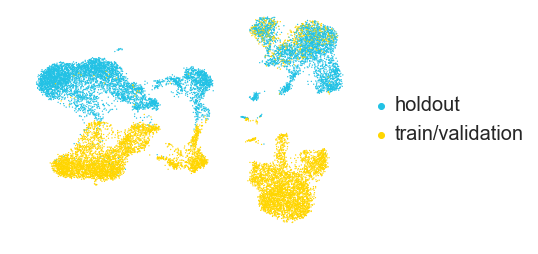

INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/heldout/6/models/scgen
cell_type  condition 
B          control        818
CD14-Mono  control       1946
           stimulated     615
CD4-T      control       2437
CD8-T      control        574
DC         control        615
F-Mono     control       1100
NK         control        517
dtype: int64
condition
control       2437
pred          2437
stimulated    3127
dtype: int64
0.7008138193424507
0.6461045616761071


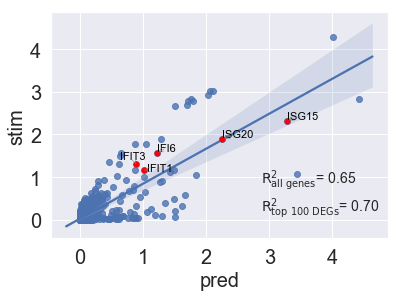

... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/violin_ISG15.pdf


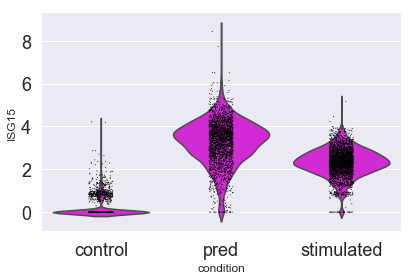

Control: 2437
Prediction: 2437
Stimulated: 3127
INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/heldout/6/models/scgen
cell_type  condition 
B          control        818
CD14-Mono  control       1946
           stimulated     615
CD4-T      control       2437
CD8-T      control        574
DC         control        615
F-Mono     control       1100
NK         control        517
dtype: int64
condition
control       1100
pred          1100
stimulated    2501
dtype: int64
0.9439883429504151
0.9493427683809131


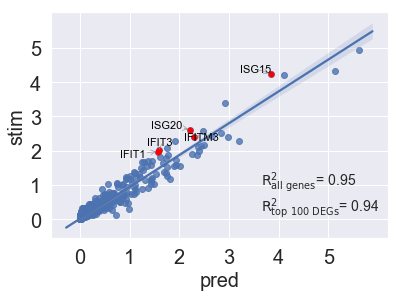

... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/violin_ISG15.pdf


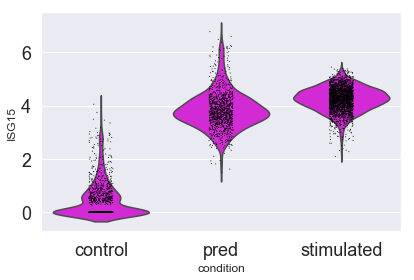

Control: 1100
Prediction: 1100
Stimulated: 2501


In [14]:
c_in = ['CD14-Mono']
c_out = ['CD4-T', 'F-Mono', 'CD8-T', 'NK', 'B', 'DC']
umap_heldout(pbmc, c_in, c_out, "c")
cell_type_analysis(pbmc, "CD4-T", 6, "c", c_in, c_out)
cell_type_analysis(pbmc, "F-Mono", 6, "c", c_in, c_out)